Conda environment for this notebook
```yml
name: geo_py312
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.12
  - gdal=3.10
  - pip
  - bottleneck
  - dask
  - folium
  - geopandas
  - httpx
  - ipykernel
  - jupyter
  - jupyterlab
  - matplotlib
  - nbformat
  - numpy
  - pandas
  - planetary-computer
  - pyproj
  - pystac
  - pystac-client
  - rasterio
  - rioxarray
  - rtree
  - scipy
  - shapely
  - xarray
  - zarr
  - pip:
    - odc-stac>=0.4
```

In [1]:
%pip install flox

Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
from datetime import datetime

from IPython.display import Image, display
from io import BytesIO

import httpx
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pyproj
import pystac
import pystac_client
import planetary_computer
import rioxarray
import scipy.signal as signal
import xarray as xr
from rasterio.features import rasterize
from shapely.geometry import box, shape
from shapely.ops import transform
from sklearn.cluster import KMeans

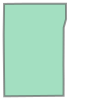

In [3]:
# get county boundary for any point
epsg = 4326
lat, lon = 41.79, -88.94

county_request = httpx.get(
    "https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2023/State_County/MapServer/13/query",
    params={
        "geometry": {"x": lon, "y": lat},
        "geometryType": "esriGeometryPoint",
        "inSR": {"wkid": epsg},
        "spatialRel": "esriSpatialRelIntersects",
        "f": "geoJSON",
    }
)

fc = county_request.json()
aoi = shape(fc["features"][0]["geometry"])
aoi

In [4]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [5]:
HLS2_L30 = "hls2-l30"
HLS2_S30 = "hls2-s30"

collections = {
    collection_id: catalog.get_collection(collection_id)
    for collection_id in [HLS2_L30, HLS2_S30]
}

In [6]:
for collection_id, collection in collections.items():
    for key, asset in collection.extra_fields["item_assets"].items():
        if collection_id == HLS2_L30 and key == "B05":
            asset["eo:bands"][0]["common_name"] = "nir08"
        if collection_id == HLS2_S30 and key == "B8A":
            asset["eo:bands"][0]["common_name"] = "nir08"
        print(collection_id, key, asset["eo:bands"][0])

hls2-l30 B01 {'name': 'B01', 'common_name': 'coastal', 'center_wavelength': 0.48, 'full_width_half_max': 0.02}
hls2-l30 B02 {'name': 'B02', 'common_name': 'blue', 'center_wavelength': 0.44, 'full_width_half_max': 0.06}
hls2-l30 B03 {'name': 'B03', 'common_name': 'green', 'center_wavelength': 0.56, 'full_width_half_max': 0.06}
hls2-l30 B04 {'name': 'B04', 'common_name': 'red', 'center_wavelength': 0.65, 'full_width_half_max': 0.04}
hls2-l30 B05 {'name': 'B05', 'common_name': 'nir08', 'center_wavelength': 0.86, 'full_width_half_max': 0.03}
hls2-l30 B06 {'name': 'B06', 'common_name': 'swir16', 'center_wavelength': 1.6, 'full_width_half_max': 0.08}
hls2-l30 B07 {'name': 'B07', 'common_name': 'swir22', 'center_wavelength': 2.2, 'full_width_half_max': 0.2}
hls2-l30 B09 {'name': 'B09', 'common_name': 'cirrus', 'center_wavelength': 1.37, 'full_width_half_max': 0.02}
hls2-l30 B10 {'name': 'B10', 'common_name': 'lwir11', 'center_wavelength': 10.9, 'full_width_half_max': 0.8}
hls2-l30 B11 {'name'

In [7]:
hls_odc_stac_config = {
    collection_id: {
        "assets": {
            "*": {
                "nodata": -9999,
                "data_type": "int16",
            },
            "Fmask": {
                "nodata": 0,
                "data_type": "uint8",
            },
        },
        "aliases": {
            asset["eo:bands"][0]["common_name"]: key
            for key, asset in collection.extra_fields["item_assets"].items()
            if asset["eo:bands"][0].get("common_name")
        }
    }
    for collection_id, collection in collections.items()
}

In [8]:
datetime_range = [datetime(2024, 4, 1), datetime(2024, 11, 1)]
bbox = aoi.bounds
search = catalog.search(
    collections=[HLS2_L30, HLS2_S30],
    datetime=datetime_range,
    bbox=bbox,
)

hls_items = search.item_collection()
print(len(hls_items))

99


In [9]:
def group_by_sensor_and_date(
    item: pystac.Item,
    parsed: odc.stac.ParsedItem,
    idx: int,
) -> str:
    id_split = item.id.split(".")
    sensor = id_split[1]
    day = id_split[3][:7]

    return f"{sensor}_{day}"

In [10]:
# load the xarray Dataset in a CONUS-wide projected CRS
target_crs = "epsg:5070"
transformer = pyproj.Transformer.from_crs(
    crs_from=epsg,
    crs_to=target_crs,
    always_xy=True,
)

aoi_5070 = transform(transformer.transform, aoi)
bbox_5070 = aoi_5070.bounds

# these are the ones that we are going to use
bands = ["red", "green", "blue", "nir08", "swir16", "swir22", "Fmask"]

stack = odc.stac.load(
    hls_items,
    stac_cfg=hls_odc_stac_config,
    bands=bands,
    crs=target_crs,
    resolution=30,
    chunks={},
    groupby=group_by_sensor_and_date,
    x=(bbox_5070[0], bbox_5070[2]),
    y=(bbox_5070[1], bbox_5070[3]),
).sortby("time")
display(stack)

<xarray.Dataset> Size: 3GB
Dimensions:      (y: 2027, x: 1073, time: 99)
Coordinates:
  * y            (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06 2.091e+06
  * x            (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05
    spatial_ref  int32 4B 5070
  * time         (time) datetime64[ns] 792B 2024-04-02T17:01:54.392140 ... 20...
Data variables:
    red          (time, y, x) int16 431MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    green        (time, y, x) int16 431MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    blue         (time, y, x) int16 431MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    nir08        (time, y, x) int16 431MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    swir16       (time, y, x) int16 431MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    swir22       (time, y, x) int16 431MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    Fmask        (time, y, x) uint8 215MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>

In [11]:
# geographic mask for the original AOI
aoi_mask = rasterize(
    [(aoi_5070, 1)],
    out_shape=(stack.rio.height, stack.rio.width),
    transform=stack.rio.transform(),
    fill=0,
    all_touched=True,
    dtype=np.uint8
).astype(bool)

In [12]:
sample_time_slice = slice("2024-07-01", None)
sample_time_idx_slice = slice(0, 6)

rgb_sample = (
    stack.to_dataarray(dim="band")
    .sel(
        time=sample_time_slice,
        band=["red", "green", "blue"]
    )
    .isel(time=sample_time_idx_slice)
    .where(aoi_mask)
    .compute()
)

/anaconda/envs/geo_py312/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


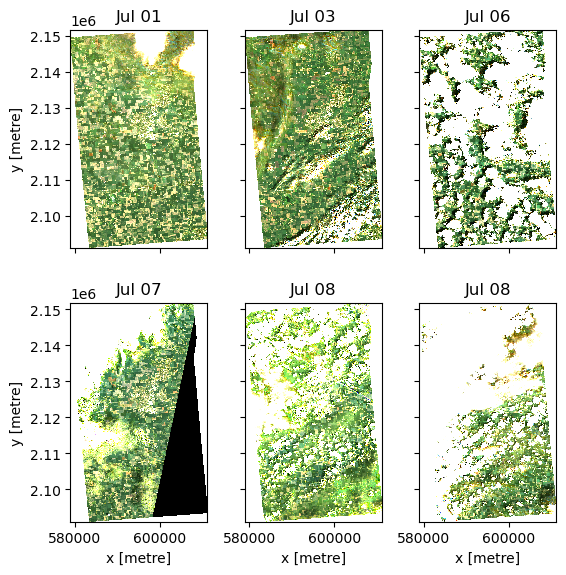

<Figure size 800x800 with 0 Axes>

In [13]:
plot_params = {
    "aspect": stack.rio.width / stack.rio.height,
    "col": "time",
    "col_wrap": 3,
    "robust": True,
    "add_labels": False,
}

rgb_plot = (
    rgb_sample
    .plot.imshow(
        rgb="band",
        vmin=0,
        vmax=1000,
        **plot_params,
    )
)

def show_plot(plot):
    for i, ax in enumerate(plot.axes.flat):
        title = ax.get_title()
        
        match = re.search(r'(\d{4}-\d{2}-\d{2})', title)
        if match:
            date_str = match.group(1)
            date_obj = datetime.strptime(date_str, '%Y-%m-%d')
            new_title = date_obj.strftime('%b %d')  # Format as "Jul 05"
            
            # Set the new title
            ax.set_title(new_title)

    plt.figure(figsize=(8, 8))
    plt.show(plot)

show_plot(rgb_plot)

In [14]:
# check for datetimes where the proportion of valid pixels is acceptable
hls_mask_bitfields = [1, 2, 3]  # cloud shadow, adjacent to cloud shadow, cloud
hls_bitmask = 0
for field in hls_mask_bitfields:
    hls_bitmask |= 1 << field

print(hls_bitmask)

14


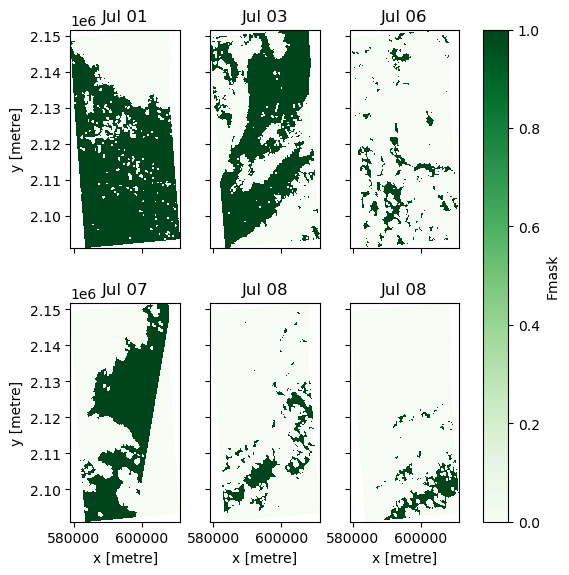

<Figure size 800x800 with 0 Axes>

In [15]:
fmask = stack["Fmask"].astype("uint16")
valid_mask = ((fmask & hls_bitmask) == 0).where(aoi_mask)
valid_plot = (
    valid_mask
    .sel(time=sample_time_slice)
    .isel(time=sample_time_idx_slice)
    .compute()
    .plot.imshow(
        vmin=0,
        vmax=1,
        cmap="Greens",
        **plot_params,
    )
)

show_plot(valid_plot)

In [16]:
valid_proportions = valid_mask.mean(dim=["x", "y"], skipna=True)

(
    valid_proportions
    .sel(time=sample_time_slice)
    .isel(time=sample_time_idx_slice)
    .compute()
)

<xarray.DataArray 'Fmask' (time: 6)> Size: 48B
array([0.67161962, 0.53758062, 0.09540152, 0.38621438, 0.09728009,
       0.07004714])
Coordinates:
    spatial_ref  int32 4B 5070
  * time         (time) datetime64[ns] 48B 2024-07-01T17:01:59.746320 ... 202...

In [17]:
valid_threshold = 0.5
valid_datetimes = (valid_proportions >= valid_threshold)

In [18]:
cloud_free_stack = (
    stack
    .where(valid_mask == 1)
    .sel(time=valid_datetimes)
)

cloud_free_stack

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 53, y: 2027, x: 1073)
Coordinates:
  * y            (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06 2.091e+06
  * x            (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05
    spatial_ref  int32 4B 5070
  * time         (time) datetime64[ns] 424B 2024-04-12T17:01:56.375150 ... 20...
Data variables:
    red          (time, y, x) float32 461MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    green        (time, y, x) float32 461MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    blue         (time, y, x) float32 461MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    nir08        (time, y, x) float32 461MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    swir16       (time, y, x) float32 461MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    swir22       (time, y, x) float32 461MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    Fmask        (time, y, x) float32 461MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>

In [19]:
cloud_free_rgb_sample = (
    cloud_free_stack.to_dataarray(dim="band")
    .sel(
        time=sample_time_slice,
        band=["red", "green", "blue"]
    )
    .isel(time=sample_time_idx_slice)
    .compute()
)

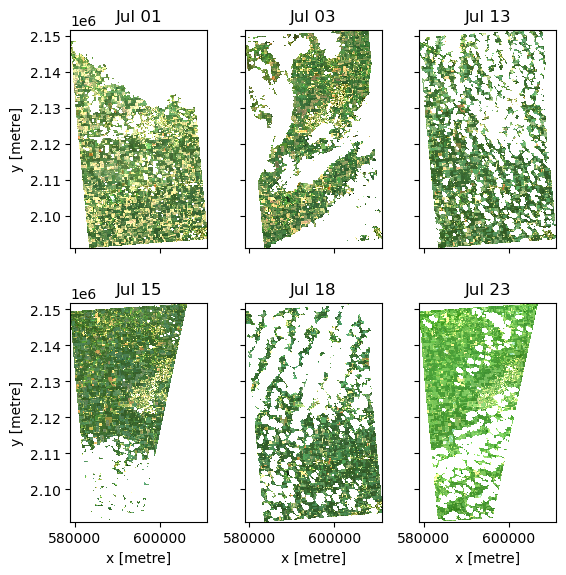

<Figure size 800x800 with 0 Axes>

In [20]:
cloud_free_plot = (
    cloud_free_rgb_sample
    .plot.imshow(
        rgb="band",
        vmin=0,
        vmax=1000,
        **plot_params,
    )
)

show_plot(cloud_free_plot)

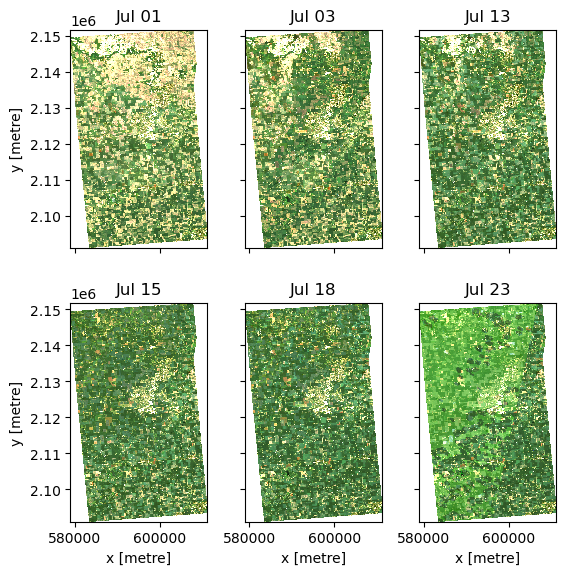

<Figure size 800x800 with 0 Axes>

In [21]:
cloud_free_rgb_sample_ffill = (
    cloud_free_stack.to_dataarray(dim="band")
    .ffill(dim="time")
    .sel(
        time=sample_time_slice,
        band=["red", "green", "blue"]
    )
    .isel(time=sample_time_idx_slice)
    .compute()
)

cloud_free_ffill_plot = (
    cloud_free_rgb_sample_ffill
    .plot.imshow(
        rgb="band",
        vmin=0,
        vmax=1000,
        **plot_params,
    )
)

show_plot(cloud_free_ffill_plot)

In [22]:
# get land cover from Impact Obseratory
landcover_collection_id = "io-lulc-annual-v02"

landcover_search = catalog.search(
    collections=landcover_collection_id,
    bbox=bbox,
)

landcover_items = landcover_search.item_collection()

landcover_stack = odc.stac.load(
    landcover_items,
    crs=target_crs,
    resolution=30,
    dtype="uint8",
    chunks={},
    x=(bbox_5070[0], bbox_5070[2]),
    y=(bbox_5070[1], bbox_5070[3]),
)["data"].squeeze()

landcover_stack

<xarray.DataArray 'data' (time: 7, y: 2027, x: 1073)> Size: 15MB
dask.array<data, shape=(7, 2027, 1073), dtype=uint8, chunksize=(1, 2027, 1073), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06 2.091e+06
  * x            (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05
    spatial_ref  int32 4B 5070
  * time         (time) datetime64[ns] 56B 2017-01-01 2018-01-01 ... 2023-01-01
Attributes:
    nodata:   0

In [23]:
baseline_landcover = landcover_stack.isel(time=-1).drop_vars("time")
baseline_landcover

<xarray.DataArray 'data' (y: 2027, x: 1073)> Size: 2MB
dask.array<getitem, shape=(2027, 1073), dtype=uint8, chunksize=(2027, 1073), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06 2.091e+06
  * x            (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05
    spatial_ref  int32 4B 5070
Attributes:
    nodata:   0

In [24]:
IO_LANDCOVER_CLASSIFICATION_VALUES = {
    0: "no data",
    1: "water",
    2: "trees",
    4: "flooded vegetation",
    5: "crops",
    7: "built area",
    8: "bare ground",
    9: "snow/ice",
    10: "clouds",
    11: "rangeland",
}

landcover_values = np.array(list(IO_LANDCOVER_CLASSIFICATION_VALUES.keys()))

landcover_labels = np.array(list(IO_LANDCOVER_CLASSIFICATION_VALUES.values()))

label_mapping = xr.DataArray(
    landcover_values,
    dims=["landcover_class"],
    coords={"landcover_class": landcover_labels}
)

cloud_free_with_landcover = (
    cloud_free_stack
    .assign_coords(
        coords={"landcover_class": (("y", "x"), baseline_landcover.data)}
    )
)
cloud_free_with_landcover


<xarray.Dataset> Size: 3GB
Dimensions:          (time: 53, y: 2027, x: 1073)
Coordinates:
  * y                (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06
  * x                (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05
    spatial_ref      int32 4B 5070
  * time             (time) datetime64[ns] 424B 2024-04-12T17:01:56.375150 .....
    landcover_class  (y, x) uint8 2MB dask.array<chunksize=(2027, 1073), meta=np.ndarray>
Data variables:
    red              (time, y, x) float32 461MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    green            (time, y, x) float32 461MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    blue             (time, y, x) float32 461MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    nir08            (time, y, x) float32 461MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    swir16           (time, y, x) float32 461MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    swir22           (time, y, x) float32 461MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    Fmask            (time, y, x) float32 461MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>

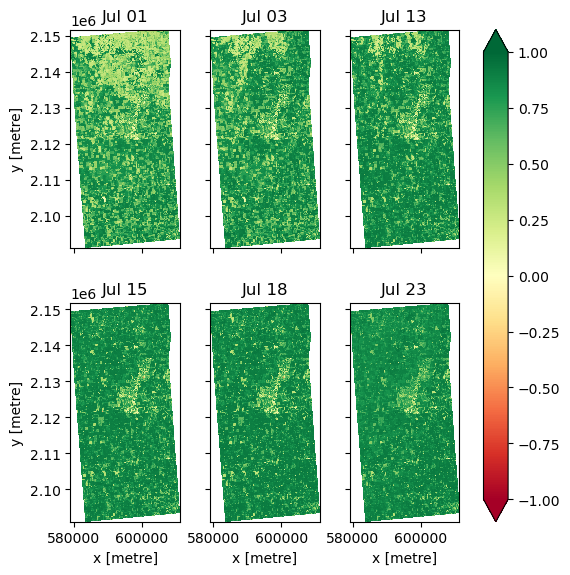

<Figure size 800x800 with 0 Axes>

In [25]:
ndvi = (
    (cloud_free_with_landcover["nir08"] - cloud_free_with_landcover["red"]) / 
    (cloud_free_with_landcover["nir08"] + cloud_free_with_landcover["red"])
)
ndvi = ndvi.where(np.isfinite(ndvi))

ndvi_sample_ffill = (
    ndvi
    .ffill(dim="time")
    .sel(
        time=sample_time_slice,
    )
    .isel(time=sample_time_idx_slice)
    .compute()
)

ndvi_plot = (
    ndvi_sample_ffill
    .plot.imshow(
        vmin=-1,
        vmax=1,
        cmap="RdYlGn",
        **plot_params,
    )
)

show_plot(ndvi_plot)

In [29]:
landcover_ndvi = (
    ndvi
    .groupby(
        landcover_class=xr.groupers.UniqueGrouper(labels=landcover_values)
    )
    .mean(dim=["x", "y"], skipna=True)
    .chunk({"time": -1})
    .interpolate_na(dim="time", method="linear", limit=3)
    .rolling(time=3, center=True)
    .mean()
    .assign_coords(
        coords={"landcover_name": ("landcover_class", landcover_labels)}
    )
    .rename("ndvi")
    .compute()
)

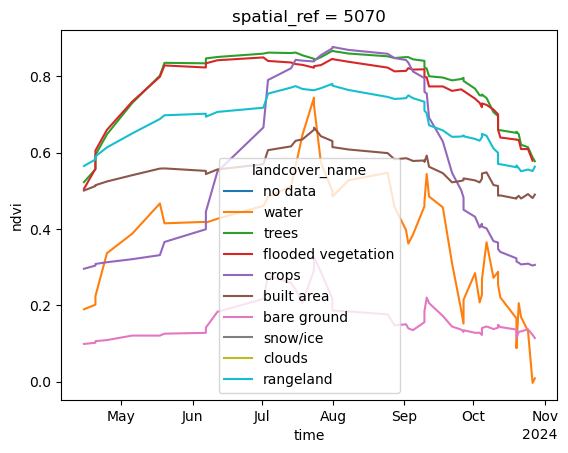

In [30]:
xr.plot.line(
    landcover_ndvi,
    x="time",
    hue="landcover_name"
)

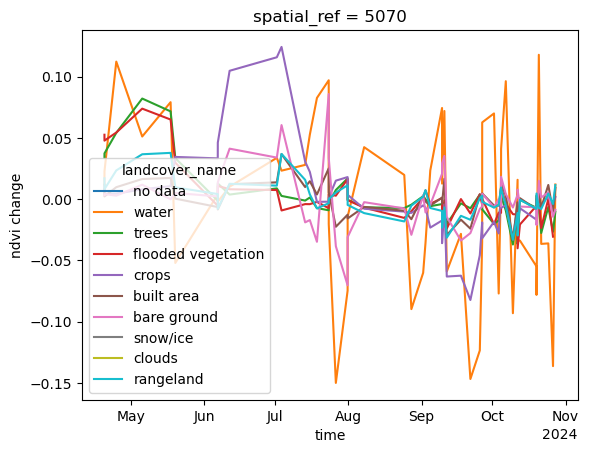

In [31]:
avg_landcover_ndvi_delta = landcover_ndvi.diff(dim="time", n=1).rename("ndvi change")

xr.plot.line(
    avg_landcover_ndvi_delta,
    x="time",
    hue="landcover_name"
)

In [32]:
avg_landcover_ndvi_delta

<xarray.DataArray 'ndvi change' (time: 52, landcover_class: 10)> Size: 2kB
array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan],
       [            nan,  1.20083690e-02,  3.37652564e-02,
         5.26186228e-02,  8.24916363e-03,  1.18022561e-02,
         3.14912200e-03,             nan,             nan,
         1.70224905e-02],
       [            nan,  2.26438642e-02,  3.73940468e-02,
         4.77975011e-02,  4.35411930e-03,  2.23147869e-03,
         4.15538251e-03,             nan,             nan,
         8.16082954e-03],
       [            nan,  1.12335414e-01,  5.41586876e-02,
         5.44009209e-02,  4.51803207e-03,  9.78207588e-03,
         2.83753872e-03,             nan,             nan,
         2.34708190e-02],
       [            nan,  5.11623323e-02,  8.21652412e-02,
         7.39200115e-02,  7.97659159e-03,  1.64384842e-02,
         1.18272677e-02,             nan,             nan,
         3.66696119e-02],
...
       [            nan, -3.65324616e-02, -2.76353359e-02,
        -2.35320926e-02, -4.32497263e-03, -6.91968203e-03,
         1.38400495e-03,             nan,             nan,
        -8.04162025e-03],
       [            nan, -3.61263603e-02, -6.40690327e-03,
         1.51395798e-04,  2.03639269e-03,  1.15946531e-02,
         5.48289716e-03,             nan,             nan,
         4.60183620e-03],
       [            nan, -1.36348635e-01, -2.66163349e-02,
        -3.06379795e-02, -4.98098135e-03, -1.04658008e-02,
        -1.44107565e-02,             nan,             nan,
        -3.94684076e-03],
       [            nan,  1.19822500e-02, -1.02260113e-02,
                    nan,  1.73586607e-03,  9.19511914e-03,
        -8.62699002e-03,             nan,             nan,
         1.14756823e-02],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan]], dtype=float32)
Coordinates:
    spatial_ref      int32 4B 5070
  * time             (time) datetime64[ns] 416B 2024-04-14T16:52:02.107540 .....
  * landcover_class  (landcover_class) int64 80B 0 1 2 4 5 7 8 9 10 11
    landcover_name   (landcover_class) <U18 720B 'no data' ... 'rangeland'

In [37]:
baseline_pixel_specific_delta_ts = avg_landcover_ndvi_delta.sel(landcover_class=baseline_landcover)
baseline_pixel_specific_delta_ts

<xarray.DataArray 'ndvi change' (time: 52, y: 2027, x: 1073)> Size: 452MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.00824916,  0.00824916,  0.00824916, ...,  0.01180226,
          0.00824916,  0.00824916],
        [ 0.00824916,  0.00824916,  0.00824916, ...,  0.00824916,
          0.00824916,  0.00824916],
        [ 0.00824916,  0.00824916,  0.00824916, ...,  0.00824916,
          0.00824916,  0.00824916],
...
          0.00173587,  0.00173587],
        [ 0.00173587,  0.00173587,  0.00173587, ...,  0.00173587,
          0.00173587,  0.00173587],
        [ 0.00173587,  0.00173587,  0.00173587, ...,  0.00173587,
          0.00173587,  0.00173587]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]],
      shape=(52, 2027, 1073), dtype=float32)
Coordinates:
    spatial_ref      int32 4B 5070
  * time             (time) datetime64[ns] 416B 2024-04-14T16:52:02.107540 .....
    landcover_class  (y, x) int64 17MB 5 5 5 5 5 5 5 5 5 5 ... 5 5 7 7 5 5 5 5 5
    landcover_name   (y, x) <U18 157MB 'crops' 'crops' ... 'crops' 'crops'
  * y                (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06
  * x                (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05

In [66]:
smoothed_ndvi = ndvi.chunk(time=-1).rolling(time=3, center=True).mean()


pixel_ndvi_delta_smoothed = smoothed_ndvi.diff(dim="time", n=1)

deviation_over_time = pixel_ndvi_delta_smoothed - baseline_pixel_specific_delta_ts
deviation_over_time

<xarray.DataArray (time: 52, y: 2027, x: 1073)> Size: 452MB
dask.array<sub, shape=(52, 2027, 1073), dtype=float32, chunksize=(51, 2027, 1073), chunktype=numpy.ndarray>
Coordinates:
  * y                (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06
  * x                (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05
    spatial_ref      int32 4B 5070
  * time             (time) datetime64[ns] 416B 2024-04-14T16:52:02.107540 .....
    landcover_class  (y, x) uint8 2MB 5 5 5 5 5 5 5 5 5 5 ... 5 5 7 7 5 5 5 5 5
    landcover_name   (y, x) <U18 157MB 'crops' 'crops' ... 'crops' 'crops'

In [67]:
time_context_threshold = deviation_over_time.quantile(
    0.05,           # Targeting the 5th percentile for negative anomalies
    dim=["y", "x"], # Calculate statistics over the spatial dimensions
    skipna=True
).compute()

time_context_threshold

<xarray.DataArray (time: 52)> Size: 208B
array([        nan, -0.02052128, -0.01232624, -0.01768026, -0.02851057,
       -0.02127549, -0.05507749, -0.0548485 , -0.05681663, -0.09816701,
       -0.10692742, -0.11175817, -0.03233416, -0.02843193, -0.01424192,
       -0.02178537, -0.01074627, -0.03215073, -0.03162029, -0.01204537,
       -0.01820891, -0.02385571, -0.03399203, -0.03456279, -0.03327895,
       -0.05371131, -0.04042315, -0.03970999, -0.01710852, -0.06121945,
       -0.06049114, -0.0625532 , -0.03835673, -0.02275229, -0.03459875,
       -0.03798563, -0.04758024, -0.02688581, -0.02283607, -0.02963687,
       -0.04345525, -0.02610536, -0.0380052 , -0.02903393, -0.03663171,
       -0.02448648, -0.02252132, -0.0286835 , -0.03158741, -0.0297537 ,
       -0.02606637,         nan], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 416B 2024-04-14T16:52:02.107540 ... 2024-...
    quantile  float64 8B 0.05

In [68]:
is_anomalous_event_time_ctx = (deviation_over_time < time_context_threshold).compute()
is_anomalous_event_time_ctx

<xarray.DataArray (time: 52, y: 2027, x: 1073)> Size: 113MB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]],
      shape=(52, 2027, 1073))
Coordinates:
  * y                (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06
  * x                (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05
    spatial_ref      int32 4B 5070
  * time             (time) datetime64[ns] 416B 2024-04-14T16:52:02.107540 .....
    landcover_class  (y, x) uint8 2MB 5 5 5 5 5 5 5 5 5 5 ... 5 5 7 7 5 5 5 5 5
    landcover_name   (y, x) <U18 157MB 'crops' 'crops' ... 'crops' 'crops'
    quantile         float64 8B 0.05

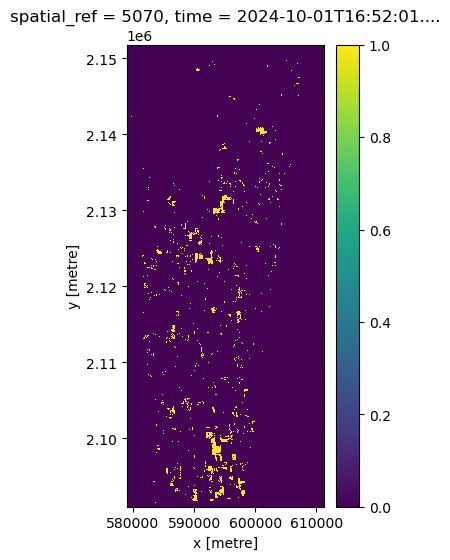

In [69]:
is_anomalous_event_time_ctx.astype(int).isel(time=35).plot.imshow(
    robust=True,
    aspect=stack.rio.width / stack.rio.height,
    size=6,
)

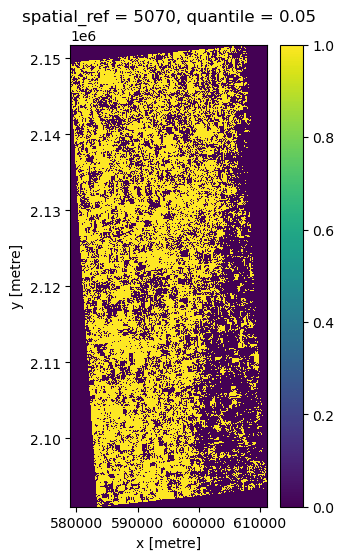

In [70]:
had_an_anomaly_mask_ctx = is_anomalous_event_time_ctx.any(dim="time").compute()
had_an_anomaly_mask_ctx.astype(int).plot.imshow(
    robust=True,
    aspect=stack.rio.width / stack.rio.height,
    size=6,
)

In [52]:
_deviation_over_time = deviation_over_time.chunk(time=-1)

def get_date_of_min_val(data_series_values, time_coords_values):
    if np.all(np.isnan(data_series_values)):
        return np.datetime64('NaT')
    min_idx = np.nanargmin(data_series_values)
    return time_coords_values[min_idx]

date_of_strongest_negative_deviation_ctx = xr.apply_ufunc(
    get_date_of_min_val,
    _deviation_over_time, # Find min in the original deviation series
    _deviation_over_time.time,
    input_core_dims=[['time'], ['time']],
    output_core_dims=[[]],
    exclude_dims=set(('time',)),
    dask="parallelized",
    vectorize=True,
    output_dtypes=[np.datetime64]
).rename("date_of_max_negative_deviation_ctx")
date_of_strongest_negative_deviation_ctx = date_of_strongest_negative_deviation_ctx.compute()


TypeError: Cannot cast NumPy timedelta64 scalar from metadata [ns] to  according to the rule 'same_kind'

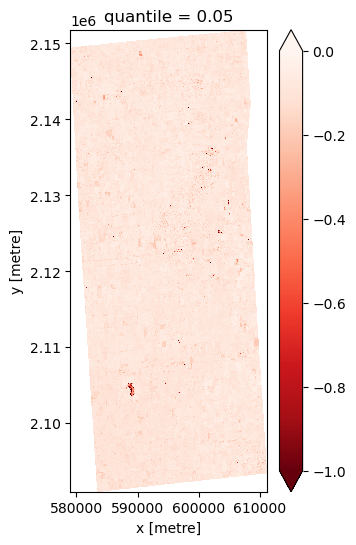

In [41]:
anomalies.plot.imshow(
    aspect=stack.rio.width / stack.rio.height,
    size=6,
    robust=True,
    vmin=-1,
    vmax=0,
    cmap="Reds_r"
)

In [42]:
(anomalies * -1 / 0.2).quantile(0.1)

<xarray.DataArray ()> Size: 8B
array(0.28690573)
Coordinates:
    quantile  float64 8B 0.1


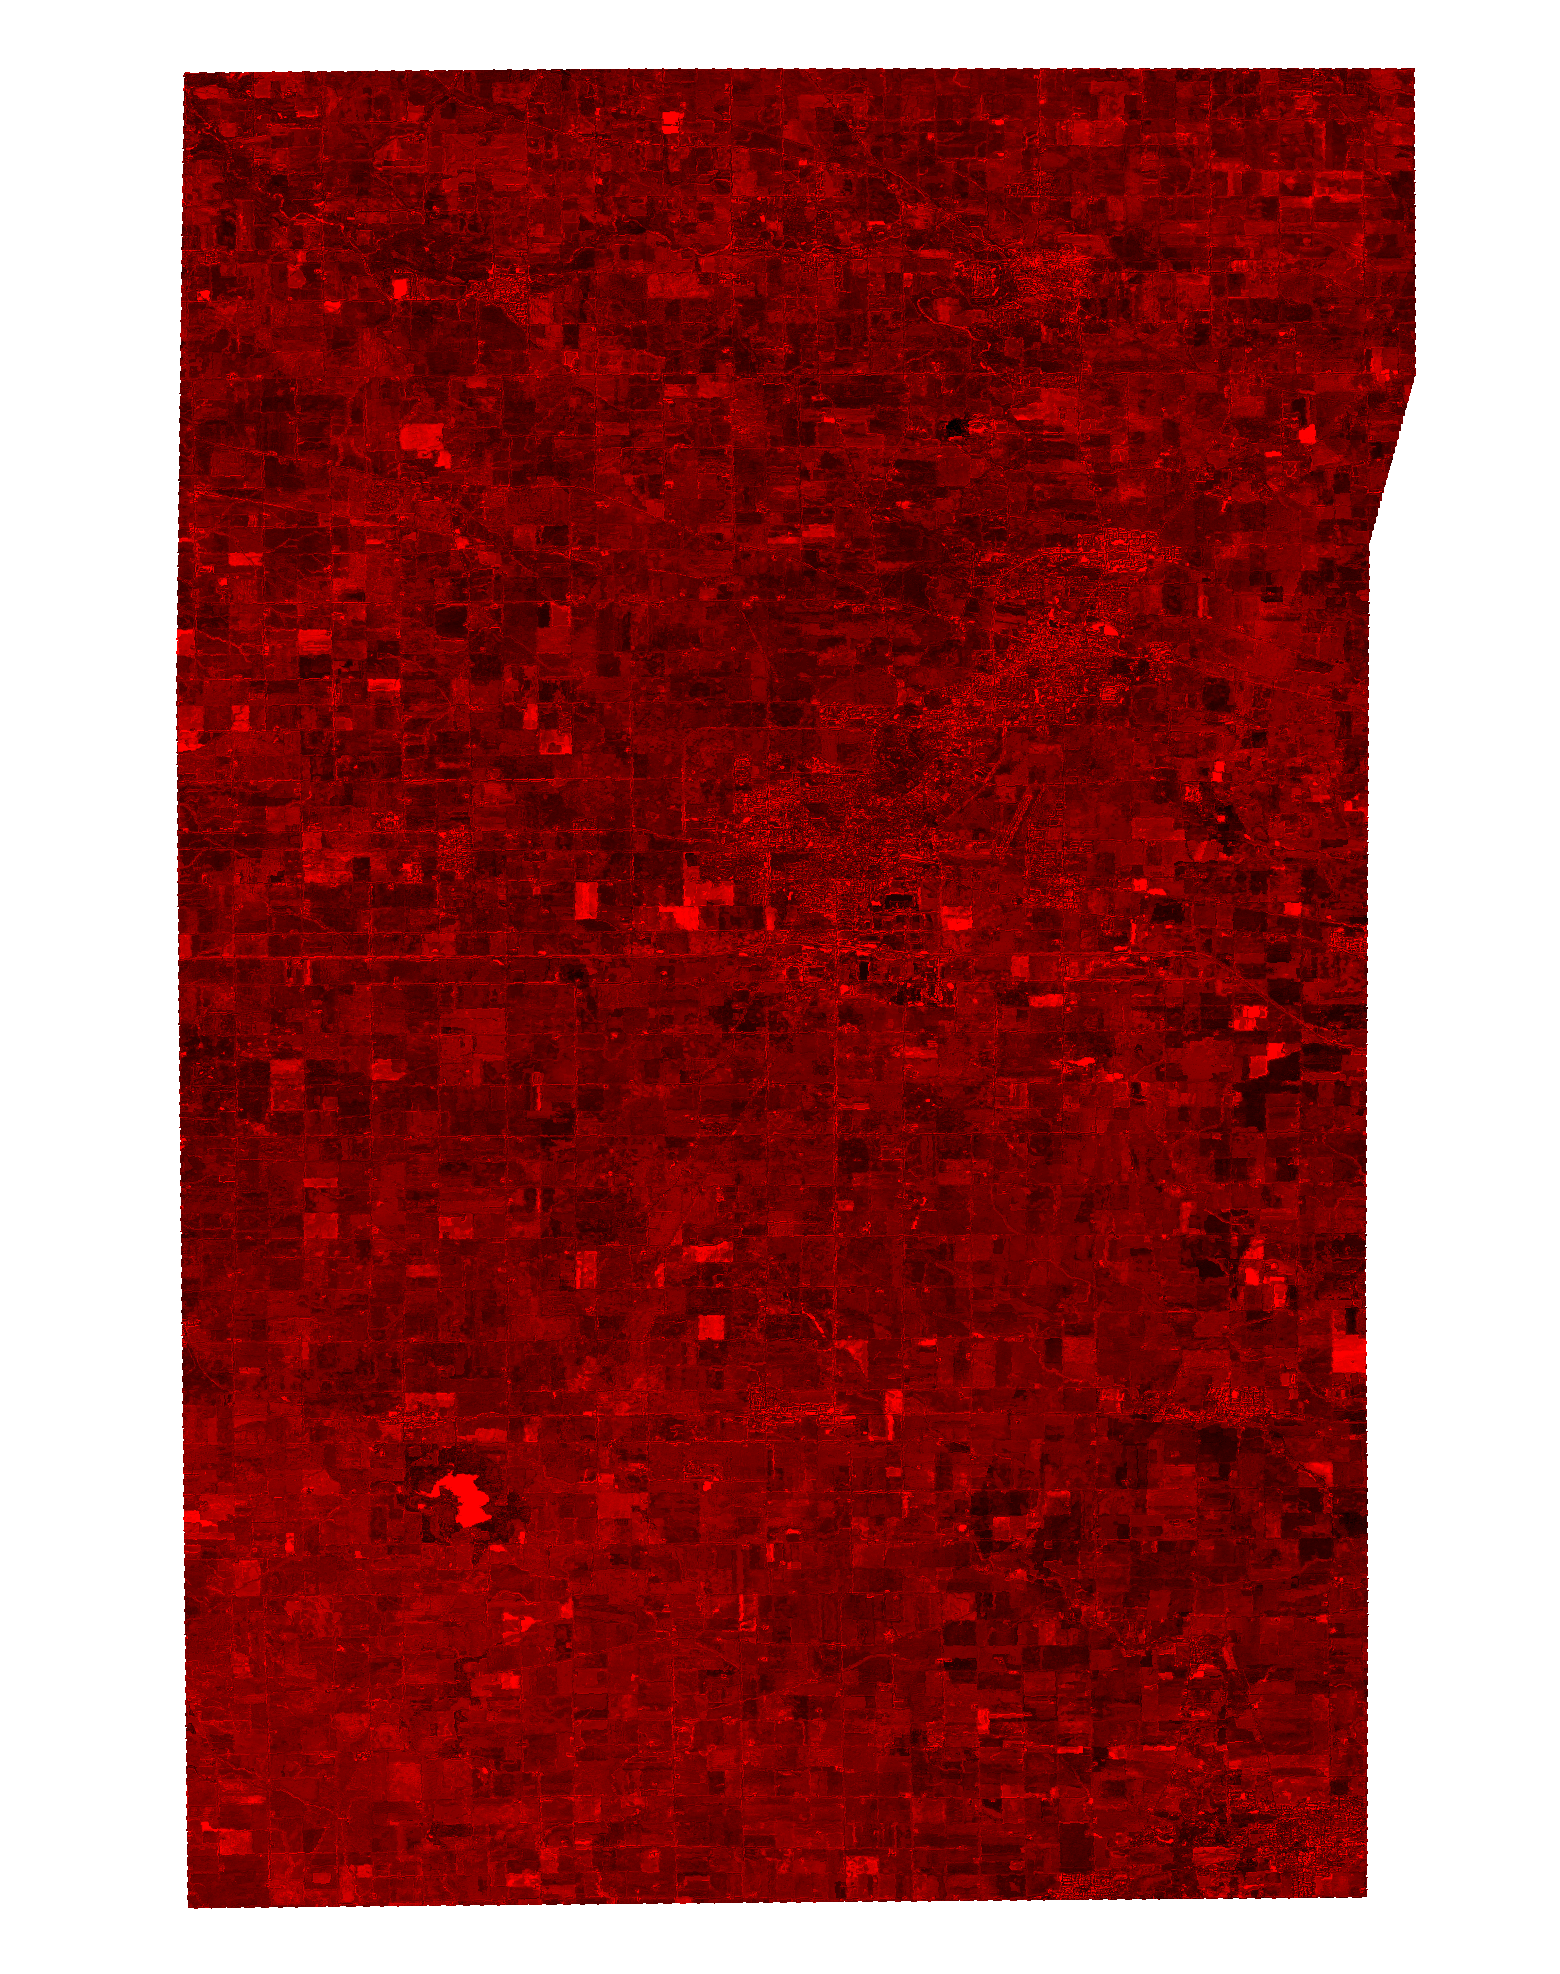

In [50]:
import folium
from rasterio.warp import transform_bounds


# rescale the array for plotting
anomalies.rio.set_crs(target_crs)
anomalies_4326 = anomalies.rio.reproject("epsg:4326")
img = (anomalies_4326 * -1 / 0.2).data
minx, miny, maxx, maxy = anomalies_4326.rio.bounds()

m = folium.Map([lat, lon], zoom_start=10, width="80%", height="80%")

def gradient_colormap(x):
    """Convert normalized data to a blue-red gradient."""
    if np.isnan(x):
        return (0, 0, 0, 0)  # Transparent for NaN values
    else:
        # Ensure x is between 0 and 1
        x_clamped = max(0, min(1, x))
        # Blue (cold) to Red (hot) gradient
        return (x_clamped, 0, 0, 1.0)

folium.raster_layers.ImageOverlay(
    name="ndvi anomalies",
    image=img,
    bounds=[[miny, minx], [maxy, maxx]],
    colormap=gradient_colormap,
).add_to(m)

folium.LayerControl().add_to(m)

m